<a href="https://colab.research.google.com/github/Gratisfo/Parentents-and-children/blob/main/dataset_for_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making dataset for Topic Modeling

In [ ]:
import json
import requests
import csv
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
import re

# Request for corpora

In [ ]:
# get metadata from rus corpus
r = requests.get("https://dracor.org/api/corpora/rus/metadata")

In [ ]:
parsedResponse = json.loads(r.text)
# create list for the names of the playes
play_name = [res['name'] for res in parsedResponse]
print(len(play_name))

211


# Get replicas from play

In [ ]:
def get_soup(title):
  url = "https://dracor.org/api/corpora/rus/play/{}/tei".format(title)
  download = requests.get(url)
  soup = BeautifulSoup(download.text, 'lxml')
  return soup

In [ ]:
def get_family(soup):
  ''' the dictionary is designed to determine family ties between characters. 
      the key is the character, and the value is a list of his parents or children, including himself '''
  fams = {}
  for rel in soup.find_all('relation'):
    if rel['name'] == 'parent_of':
      fam = re.findall(r"(#.*?)\W", str(rel))
      for i in fam:
        fams[i] = fam   
  return fams

In [ ]:
def get_text(scene, fams):
  text = ''

  # find all replicas
  res = scene.find_all('sp')

  for i, idx in enumerate(res):
    # get speaker name
    speaker = idx.get('who')

    # check if speaker is parent or child
    # by his/her presence in fams dict 
    if speaker in fams.keys():
      try:

        # get info about speaker' family members from dict
        rels = fams[speaker]

        #check previous and next speaker
        prev = res[i-1].get('who')
        next = res[i+1].get('who')

        # chek if he\she is speaker's realtive
        if prev or next in rels:

          # join family members relicas in one chunk of text
          if soup.sp.l:
            text += " " + idx.l.string
          else:
            text += " " + idx.p.string
      except:
        pass  
  return text

In [ ]:
def play_info(title, soup):
  fams = get_family(soup)
  scenes = soup.find_all("div", {"type": "scene"})
  date = [p['yearWritten'] for p in parsedResponse if p['playName'] == title][0]
  author = [p['firstAuthor'] for p in parsedResponse if p['playName'] == title][0]
  title = soup.title.string
  texts = []
  for scene in scenes:
    text = get_text(scene, fams)
    texts.append(text)
  texts = [text.replace('\n            ', '') for text in texts if len(text) > 1]
  return title, author, date, texts

In [ ]:
data = pd.DataFrame(columns=["title", "author", "date", "text"])
for name in play_name:
  soup = get_soup(name)
  if len(soup.find_all('relation', {"name": "parent_of"})) > 0:
    title, author, date, texts = play_info(name, soup)
    for text in texts:
      data = data.append({'title': title, "author": author, "date": date, "text": text}, ignore_index=True)

# Prerpocessing text

In [91]:
! pip install natasha

     |████████████████████████████████| 34.4MB 111kB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 8.2MB 33.1MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26102 sha256=07d829f5881c7ee01ca9c7674d9a82a4b8be4a387065dd04c984711472dc0943
  Stored in directory: /root/.cache/pip/wheels/f3/f2/66/e9c30d3e9499e65ea2fa0d07c002e64de63bd0adaa49c445bf
Successfully built intervaltree
  Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [92]:
!pip install razdel

In [93]:
from natasha import (
    Segmenter,
    MorphVocab,
    Doc,
    DatesExtractor,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)

In [94]:
import re
import pymorphy2
import nltk
from razdel import sentenize, tokenize
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [95]:
def del_ner(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_ner(ner_tagger)
  list_ner = []
   
  # create ner list 
  for i, elem in enumerate(doc.spans):
      list_ner.append((list(doc.spans[i]))[3])

  # del ner
  for i in list_ner:
      if i in text:
          text = text.replace(i, '') 
  return text

In [96]:
def preproc_text(text):

  # delete ner
  text = del_ner(text) 

  # tokenize
  tokens = [_.text for _ in list(tokenize(text))]
  
  # lower register
  tokens = [w.lower() for w in tokens]
  
  # remove puntuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  
  # remove numbers, save only letters
  words = [word for word in stripped if word.isalpha()]
  
  # to normal form
  # save only nouns
  words = [morph.parse(w)[0].normal_form for w in words if morph.parse(w)[0].tag.POS == "NOUN"] 

  # delete stop-words
  stop_words = stopwords.words('russian')
  stop_words = stop_words + ['мой', 'тая', 'твой', 'ваш', 'всетаки', 'свой', 'делатьто', 'такой', 'какой', 'наш', 'который']
  words = [w for w in words if w not in stop_words]
  
  return words

In [99]:
data['clean_text'] = data['text'].apply(lambda x: preproc_text(x)) 

In [ ]:
data.to_csv("data_TM.csv")

## Ranking authors by fams realtions in text

In [ ]:
def play_info_rel(title, soup):
  author = [p['firstAuthor'] for p in parsedResponse if p['playName'] == title][0]
  fams = soup.find_all('relation', {"name": "parent_of"})
  return  author, len(fams)

In [ ]:
data = pd.DataFrame(columns=["author","amount_fams"])
for name in play_name:
  soup = get_soup(name)
  if len(soup.find_all('relation', {"name": "parent_of"})) > 0:
    author, len_fams = play_info_rel(name, soup)
    data = data.append({"author": author, "amount_fams": len_fams}, ignore_index=True)

In [ ]:
aggregation_functions = {"author":'first', "amount_fams": 'sum'}
df_new = data.groupby(data['author']).aggregate(aggregation_functions)
df_new.sort_values('amount_fams', ascending=False)


,author,amount_fams
author,,
Островский,Островский,29
Чехов,Чехов,14
Сумароков,Сумароков,13
Толстой,Толстой,8
Крылов,Крылов,6
Фонвизин,Фонвизин,6
Княжнин,Княжнин,5
Мамин-Сибиряк,Мамин-Сибиряк,5
Екатерина II,Екатерина II,4


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


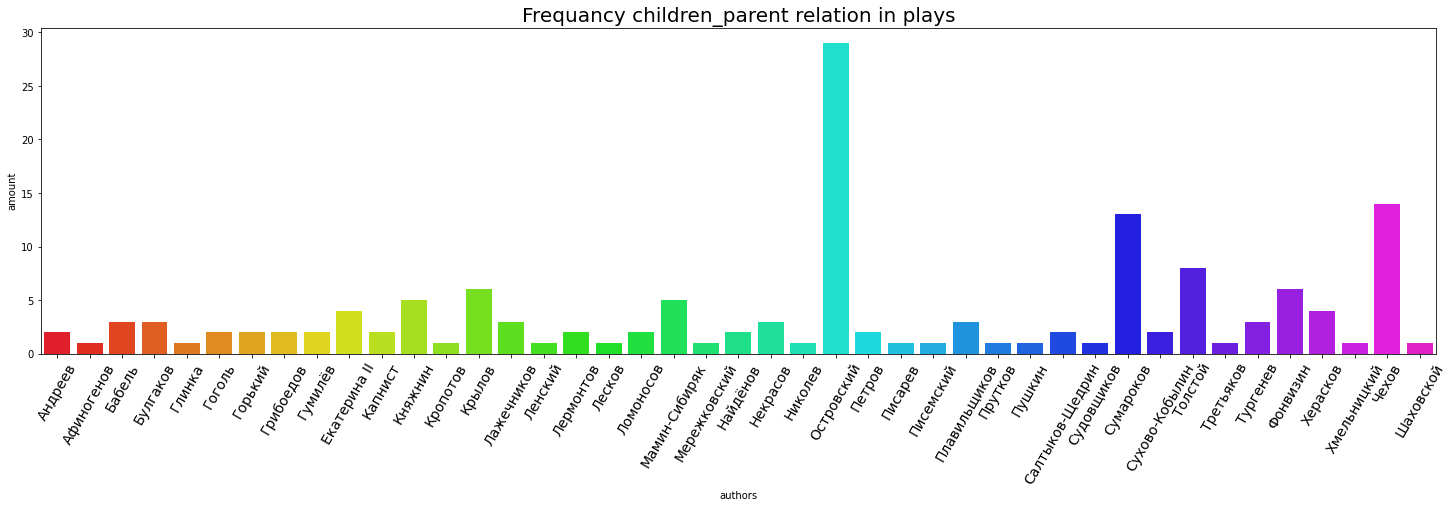

In [ ]:
import numpy as np
plt.figure(figsize=(25, 6))
x = list(range(1, len(df_new['amount_fams'])+1))
y = df_new['amount_fams']

ax = sns.barplot(x, y, palette=("gist_rainbow"))
ax.set_xlabel('authors')
ax.set_ylabel('amount')
ax.set_xticklabels(df_new['author'].tolist(),  rotation=60, fontsize=14)

ax.set_title('Frequancy children_parent relation in plays', fontsize=20)

plt.show()